In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [79]:
fires = pd.read_csv('fires.csv')
random_state = 42

In [80]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [81]:
fires.shape

(517, 14)

In [82]:
# Drop the "Unnamed: 0" column
fires = fires.drop(columns=["Unnamed: 0"])

# Exploratory data analysis
The dataset, is about meterological observations and forest fires in Portugal.
It is available [Here](https://archive.ics.uci.edu/dataset/162/forest+fires)


## Data structure

| Variable Name | Role     | Type        | Description                                                                                             | Units         | Missing Values |
|---------------|----------|-------------|---------------------------------------------------------------------------------------------------------|---------------|----------------|
| `X`           | Feature  | Integer     | x-axis spatial coordinate within the Montesinho park map: 1 to 9                                        |               | no             |
| `Y`           | Feature  | Integer     | y-axis spatial coordinate within the Montesinho park map: 2 to 9                                        |               | no             |
| `month`       | Feature  | Categorical | month of the year: 'jan' to 'dec'                                                                       |               | no             |
| `day`         | Feature  | Categorical | day of the week: 'mon' to 'sun'                                                                         |               | no             |
| `FFMC`        | Feature  | Continuous  | FFMC index from the FWI system: 18.7 to 96.20                                                           |               | no             |
| `DMC`         | Feature  | Integer     | DMC index from the FWI system: 1.1 to 291.3                                                             |               | no             |
| `DC`          | Feature  | Continuous  | DC index from the FWI system: 7.9 to 860.6                                                              |               | no             |
| `ISI`         | Feature  | Continuous  | ISI index from the FWI system: 0.0 to 56.10                                                             |               | no             |
| `temp`        | Feature  | Continuous  | temperature: 2.2 to 33.30                                                                               | Celsius       | no             |
| `RH`          | Feature  | Integer     | relative humidity: 15.0 to 100                                                                          | %             | no             |
| `wind`        | Feature  | Continuous  | wind speed: 0.40 to 9.40                                                                                | km/h          | no             |
| `rain`        | Feature  | Integer     | outside rain: 0.0 to 6.4                                                                                | mm/m²         | no             |
| `area`        | Target   | Integer     | the burned area of the forest: 0.00 to 1090.84  | ha            | no             |

The [Fire Weather Index (FWI)](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi) is a system to assign a
numerical value to risk of forest fires. The hierarchy of how these observations are tied together is shown in this
image

![FWI System](FWI.png)


The 4 values in this data set from it are
- `FFMC` : Fine Fuel Moisture Code (dry grass and small twigs)
- `DMC` : Duff Moisture Code (moisture content of medium -ized organic material, it is sensitive to rainfall and
temperature)
- `DC`: Drought Code
- `ISI`: Initial Spread Index

From the [paper](https://www.semanticscholar.org/paper/A-data-mining-approach-to-predict-forest-fires-data-Cortez-Morais/0f529dc2b2b2bad22394454d4cba79e2c319f0b0);
*Also, the fuel moisture codes require a memory (time lag) of past weather conditions: 16 hours for
FFMC, 12 days for DMC and 52 days for DC*.

Also of note from the paper, burned area is 0 if the area burned was under 100 m2. Each of these entries is a fire
event. That means that there is actually a binomial distribution of area burned under log scale, but we're ignoring
everything under 100 m2

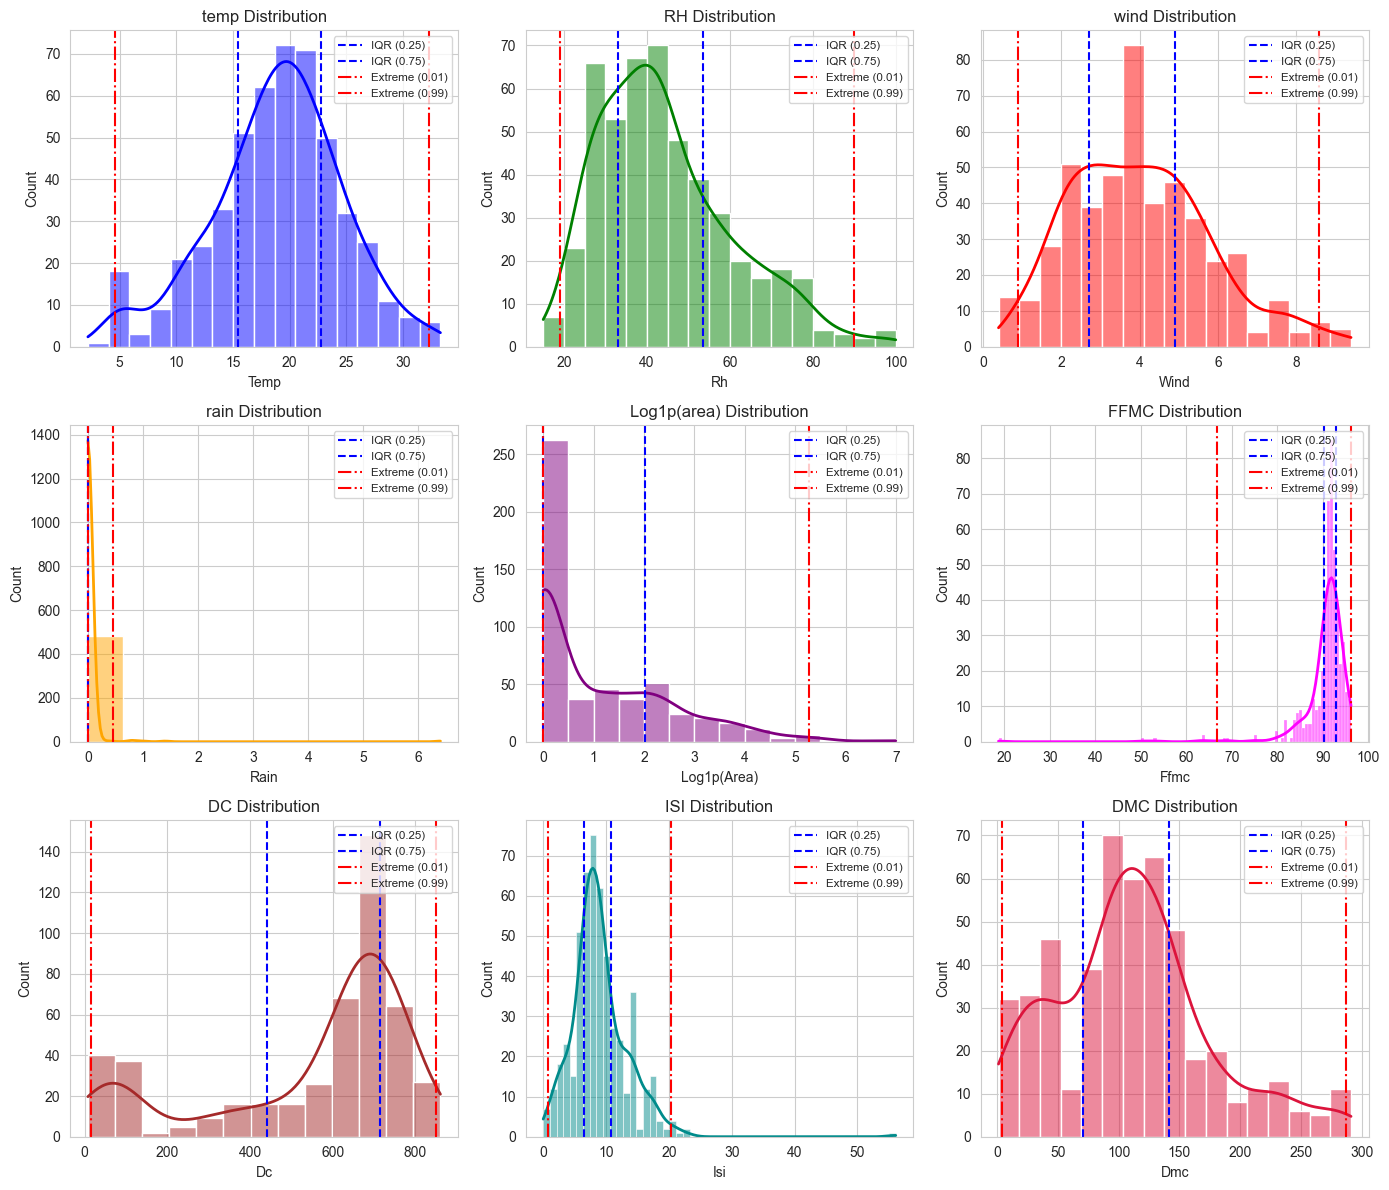

In [83]:
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
axes = axes.flatten()

# Define a list of high-contrast colors
colors = ['blue', 'green', 'red', 'orange', 'purple', 'magenta', 'brown', 'darkcyan', 'crimson']

for i, col in enumerate(['temp', 'RH', 'wind', 'rain', 'area', 'FFMC', 'DC', 'ISI', 'DMC']):
    if col in ['area']:
        sns.histplot(np.log1p(fires[col]), bins='auto', kde=True, ax=axes[i], color=colors[i],
                     line_kws={'linewidth': 2, 'color': 'black'}
                     )
        axes[i].set_title(f'Log1p({col}) Distribution')
        axes[i].set_xlabel(f'Log1p({col.capitalize()})')

        # Calculate IQR (0.25 and 0.75 quantiles) and extreme range (0.01 and 0.99 quantiles)
        q25, q75 = np.log1p(fires[col]).quantile([0.25, 0.75])
        q01, q99 = np.log1p(fires[col]).quantile([0.01, 0.99])
    else:
        sns.histplot(fires[col], bins='auto', kde=True, ax=axes[i], color=colors[i],
                     line_kws={'linewidth': 2, 'color': 'black'}
                     )
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col.capitalize())

        # Calculate IQR (0.25 and 0.75 quantiles) and extreme range (0.01 and 0.99 quantiles)
        q25, q75 = fires[col].quantile([0.25, 0.75])
        q01, q99 = fires[col].quantile([0.01, 0.99])

    # Add vertical lines for IQR range
    axes[i].axvline(q25, color='blue', linestyle='--', label='IQR (0.25)')
    axes[i].axvline(q75, color='blue', linestyle='--', label='IQR (0.75)')

    # Add vertical lines for extreme range
    axes[i].axvline(q01, color='red', linestyle='-.', label='Extreme (0.01)')
    axes[i].axvline(q99, color='red', linestyle='-.', label='Extreme (0.99)')

    # Add legend to the plot
    axes[i].legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

In [84]:
# Create a log1p column in the fires dataframe
fires['log1p_area'] = np.log1p(fires['area'])

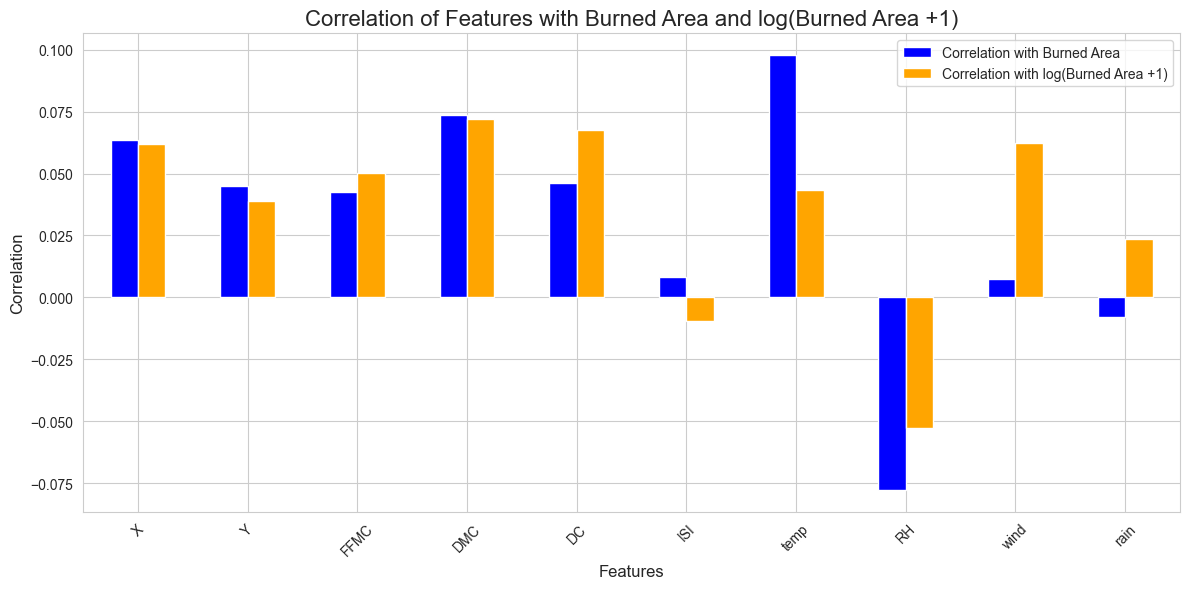

In [85]:
from matplotlib import pyplot as plt

# Create a bar plot for visualization with hue based on correlation values
# Calculate correlation for the log of the burned area +1
log_area = np.log1p(fires['area'])
numeric_features = fires.select_dtypes(include=[np.number])
log_area_correlation = numeric_features.corrwith(log_area)

# Combine correlations into a dataframe for visualization
area_correlation = numeric_features.corrwith(fires['area'])
correlation_df = pd.DataFrame({
        'Feature'                             : area_correlation.index,
        'Correlation with Burned Area'        : area_correlation.values,
        'Correlation with log(Burned Area +1)': log_area_correlation.values
}
).drop(index=['area', 'log1p_area'], errors='ignore').set_index('Feature')  # Exclude area and log1p_area

correlation_df = correlation_df.loc[~correlation_df.index.isin(['area', 'log1p_area'])]  # Ensure exclusion

correlation_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])
plt.title('Correlation of Features with Burned Area and log(Burned Area +1)', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The correlation of these features with area burned is not surprising, with temperature being the strongest positive
correlation and Relative Humidity and rainfall being the strongest negative correlations.

In [86]:
# For each feature in dataset, determine missing or NA values
missing_values = fires.isna().sum()
print("Missing or NA values for each feature:")
print(missing_values)

Missing or NA values for each feature:
X              0
Y              0
month          0
day            0
FFMC          48
DMC           21
DC            43
ISI            2
temp          21
RH            30
wind          35
rain          32
area           0
log1p_area     0
dtype: int64


In [87]:
fires_reference = fires[["wind", "temp", "area"]].dropna()
reference_x = fires_reference[["wind", "temp"]]
reference_y = fires_reference["area"]
reference_model = LinearRegression()

# Data cleaning

There are some missing data for many of the features, so we'll need a way to impute them

- `month` - potentially useful, correlates with season and weather
- `day` - day of the week, unlikely to be useful if we don't know the exact date. Data was collected between Jan 2000
 and Dec 2003
- `FFMC` - 48 missing values, need to impute
- `DMC` - 21 missing values, need to impute
- `DC` - 43 missing values, need to impute
- `ISI` - 2 missing values, need to impute
- `temp` - 21 missing values, need to impute
- `RH` - 30 missing values, need to impute
- `wind` - 35 missing values, need to impute
- `rain` - 32 missing values, need to impute


In [88]:
# Some rows are missing data, how is the missing data distributed?
missing_counts = fires.isna().sum(axis=1)
print("Row entries with missing data")
print(missing_counts.value_counts().sort_index())

Row entries with missing data
0    329
1    148
2     36
3      4
Name: count, dtype: int64


In [89]:
rows_with_3_missing = fires[missing_counts == 3]
rows_with_3_missing_df = pd.DataFrame(rows_with_3_missing)
print("Rows with 3 missing or NA values:")
rows_with_3_missing_df.head()

Rows with 3 missing or NA values:


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log1p_area
48,4,4,mar,mon,NaN,23.9,NaN,4.1,11.8,35.0,NaN,0.0,0.00,0.000000
124,3,4,sep,fri,NaN,85.1,692.3,15.9,19.8,NaN,NaN,0.0,0.00,0.000000
270,2,2,aug,tue,NaN,152.6,NaN,14.3,NaN,56.0,3.1,0.0,0.52,0.418710
279,4,4,dec,mon,NaN,25.4,349.7,2.6,4.6,NaN,8.5,NaN,9.77,2.376764


In [90]:
rows_with_2_missing = fires[missing_counts == 2]
rows_with_2_missing_df = pd.DataFrame(rows_with_2_missing)
print("Rows with 2 missing or NA values:")
rows_with_2_missing_df.head()

Rows with 2 missing or NA values:


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log1p_area
17,8,5,oct,mon,84.9,32.8,NaN,3.0,16.7,47.0,4.9,NaN,0.0,0.0
31,6,3,sep,mon,88.6,91.8,709.9,7.1,11.2,NaN,7.6,NaN,0.0,0.0
32,6,3,sep,fri,NaN,69.7,706.8,5.8,20.6,37.0,NaN,0.0,0.0,0.0
37,7,4,oct,fri,NaN,NaN,682.6,8.7,11.3,60.0,5.4,0.0,0.0,0.0
111,3,4,mar,fri,91.7,NaN,77.5,9.0,18.8,NaN,4.5,0.0,0.0,0.0


Since there are some data with missing entries. We'll need to impute the values of the missing data.

## Missing values
Imputing the data using K Nearest Neighbours should be sufficient. For all the features except `area` and `rainfall`
we're getting normal distributions, so scaling and normalising them will work.

In [91]:
from sklearn.impute import KNNImputer

# Impute the missing values in fires using KNN
imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)  # You can adjust the number of neighbors if needed
fires_imputed = fires.copy()

# Fit the imputer and transform the numerical columns
numerical_features = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
fires_imputed[numerical_features] = imputer.fit_transform(fires[numerical_features])

# Replace the original dataset with the imputed one
fires_imputed

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log1p_area
0,7,5,mar,fri,86.2,26.20,94.30,5.1,15.54,51.0,6.7,0.0,0.00,0.000000
1,7,4,oct,tue,90.6,79.28,669.10,6.7,18.00,33.0,0.9,0.0,0.00,0.000000
2,7,4,oct,sat,90.6,43.70,438.18,6.7,14.60,33.0,1.3,0.0,0.00,0.000000
3,8,6,mar,fri,91.7,33.30,77.50,9.0,8.30,97.0,4.0,0.2,0.00,0.000000
4,8,6,mar,sun,89.3,51.30,102.20,9.6,11.40,99.0,4.3,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.70,665.60,1.9,27.80,32.0,2.7,0.0,6.44,2.006871
513,2,4,aug,sun,81.6,56.70,665.60,1.9,21.90,71.0,5.8,0.0,54.29,4.012592
514,7,4,aug,sun,81.6,56.70,665.60,1.9,21.20,70.0,6.7,0.0,11.16,2.498152
515,1,4,aug,sat,94.4,146.00,614.70,11.3,25.60,42.0,4.0,0.0,0.00,0.000000



## Feature engineering
The day of the week we'll process into weekday vs weekend. If there is a human activity component then there should
be a difference. People visit parks on weekends and potentially leave litter and other rubbish which could contribute
 to the `FFMC` value in a localised area.

For the month, we'll separate it into summer and not summer. With the expectation that hotter months in summer
correlate with increased area burned.

In [92]:
# Create a new column that labels the day as either "Weekday" or "Weekend"
fires_imputed['day_type'] = fires_imputed['day'].apply(lambda x: 'Weekend' if x in ['sat', 'sun'] else 'Weekday')

In [93]:
# Create a new column that labels the season as either "Summer" or "Not Summer"
fires_imputed['season'] = fires_imputed['month'].apply(lambda x: 'Summer' if x in ['jun', 'jul', 'aug'] else 'Not '
                                                                                                             'Summer'
                                                       )

## Outliers
Some of the distributions indicate a lot of outliers, lets check how many there are per feature

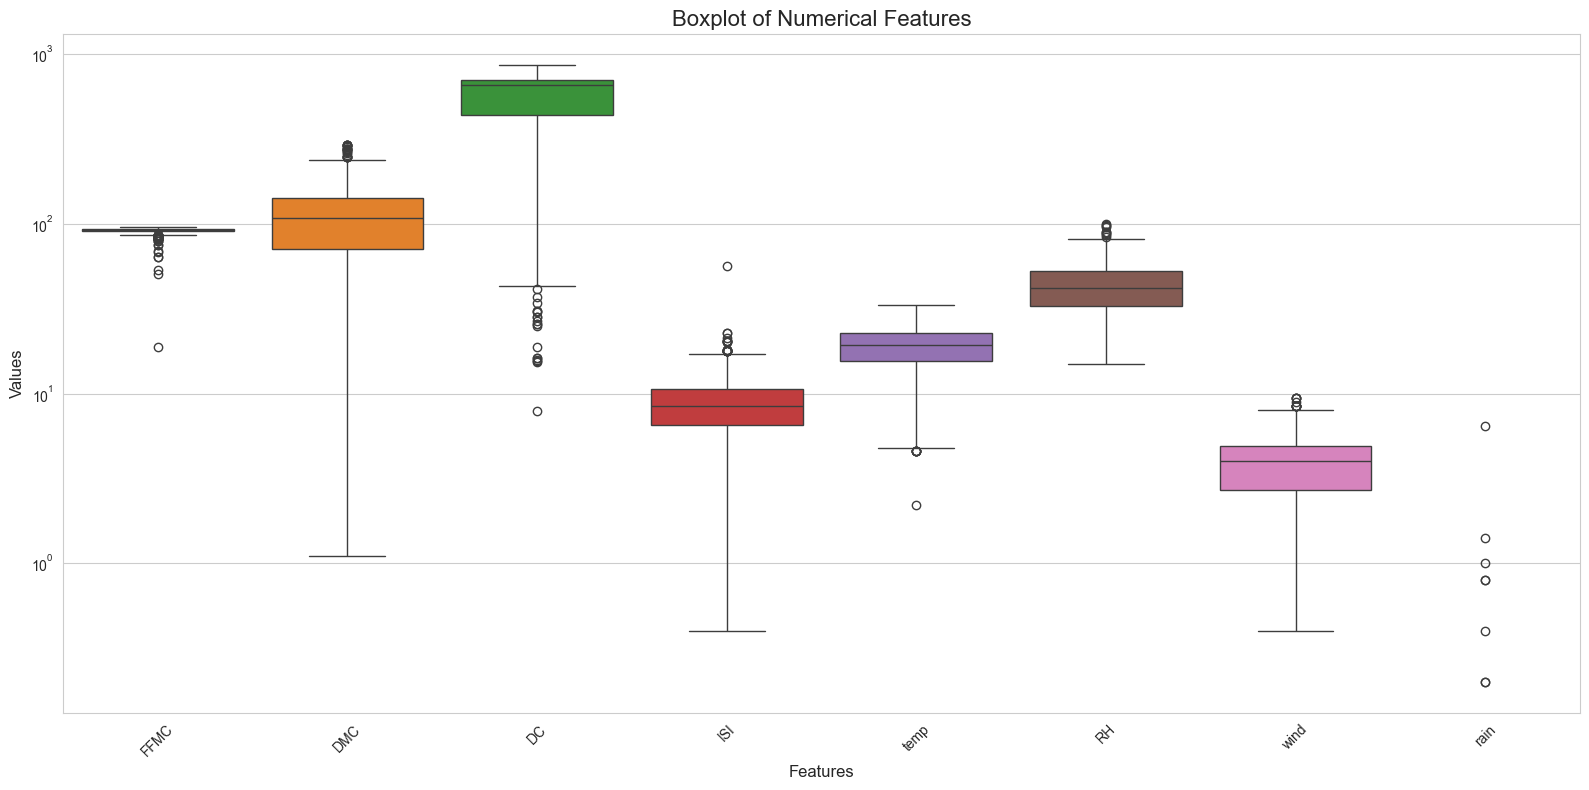

In [94]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=fires_imputed[numerical_features])
plt.yscale('log')  # Modify the y-axis to a log scale to show smaller distributions clearly
plt.title('Boxplot of Numerical Features', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

It looks like there's quite a few outliers

In [95]:
# Calculate outliers using IQR for the numerical features
Q1 = fires_imputed[numerical_features].quantile(0.25)  # First quartile
Q3 = fires_imputed[numerical_features].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range

# Identify outliers
outliers = ((fires_imputed[numerical_features] < (Q1 - 1.5 * IQR)) |
            (fires_imputed[numerical_features] > (Q3 + 1.5 * IQR))).sum()

# Print the count of outliers for each feature
print("Outliers detected in each numerical feature:")
print(outliers)

Outliers detected in each numerical feature:
FFMC    52
DMC     22
DC      19
ISI     23
temp     7
RH      10
wind    12
rain     8
dtype: int64


There's quite a few outliers, so we'll need to handle them appropriately based on distribution

# Outlier Handling and Scaling Techniques

| Feature       | Outlier Handling                                   | Scaling/Normalization Technique | Reason                                                   |
|---------------|----------------------------------------------------|---------------------------------|----------------------------------------------------------|
| `FFMC`        | Winsorization (1st & 99th percentiles)             | StandardScaler                  | Normally distributed, standardize                        |
| `DMC`         | Winsorization (1st & 99th percentiles)             | PowerTransformer (Yeo-Johnson)  | Highly skewed, log-like transformation needed            |
| `DC`          | Winsorization (1st & 99th percentiles)             | PowerTransformer (Yeo-Johnson)  | Highly skewed, Box-Cox alternative                       |
| `ISI`         | Winsorization (1st & 99th percentiles)             | StandardScaler                  | Normally distributed, standardize                        |
| `temp`        | Winsorization (1st & 99th percentiles)             | StandardScaler                  | Normally distributed, standardize                        |
| `RH`          | Winsorization (1st & 99th percentiles)             | StandardScaler                  | Normally distributed, standardize                        |
| `wind`        | Winsorization (1st & 99th percentiles)             | RobustScaler                    | Skewed, contains extreme values                          |
| `rain`        | Winsorization (1st & 99th percentiles), Log(1 + x) | MinMaxScaler                    | Highly skewed, log-scaled for normality                  |
| `burned_area` | Winsorization (1st & 99th percentiles), Log(1 + x) | StandardScaler                  | Log-normal distribution, standardize post-log            |


In [96]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler, MinMaxScaler
import pandas as pd
import numpy as np

# Handle outliers and scaling in a new DataFrame
fires_processed = fires_imputed.copy()

# Winsorization based on the 1st and 99th percentiles for all features
for col in numerical_features:
    lower_bound = fires_processed[col].quantile(0.01)
    upper_bound = fires_processed[col].quantile(0.99)
    fires_processed[col] = np.clip(fires_processed[col], lower_bound, upper_bound)

# Apply scaling/normalization based on the table
scalers = {
        'FFMC': StandardScaler(),
        'DMC' : PowerTransformer(method='yeo-johnson'),
        'DC'  : PowerTransformer(method='yeo-johnson'),
        'ISI' : StandardScaler(),
        'temp': StandardScaler(),
        'RH'  : StandardScaler(),
        'wind': RobustScaler(),
        'rain': MinMaxScaler()
}

# Scale each feature
for feature, scaler in scalers.items():
    fires_processed[feature] = scaler.fit_transform(fires_processed[[feature]])

# Log transform for 'burned_area' (log1p transformation already done as 'log1p_area')
fires_processed['burned_area'] = scaler.fit_transform(
    np.log1p(fires_processed['area']).to_frame()
)

# One-hot encode 'season' and 'day_type' columns
onehot_encoded = pd.get_dummies(fires_processed[['season', 'day_type']], drop_first=True)

# Add one-hot encoded columns to the DataFrame and drop the original categorical columns
fires_processed = pd.concat([fires_processed, onehot_encoded], axis=1).drop(columns=['month', 'day', 'season',
                                                                                     'day_type']
                                                                            )

fires_processed

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log1p_area,burned_area,season_Summer,day_type_Weekend
0,7,5,-1.146169,-1.467304,-1.797787,-0.949189,-0.588684,0.430809,1.227273,0.000000,0.00,0.000000,0.000000,False,False
1,7,4,-0.054939,-0.395598,0.486442,-0.553462,-0.157845,-0.724380,-1.409091,0.000000,0.00,0.000000,0.000000,False,False
2,7,4,-0.054939,-1.065945,-0.634962,-0.553462,-0.753313,-0.724380,-1.227273,0.000000,0.00,0.000000,0.000000,False,True
3,8,6,0.217868,-1.295730,-1.831841,0.015395,-1.856681,2.913180,0.000000,0.543478,0.00,0.000000,0.000000,False,False
4,8,6,-0.377348,-0.910098,-1.780732,0.163792,-1.313754,2.913180,0.136364,0.000000,0.00,0.000000,0.000000,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,-2.287000,-0.804287,0.467847,-1.740642,1.558505,-0.788557,-0.590909,0.000000,6.44,2.006871,0.286875,True,True
513,2,4,-2.287000,-0.804287,0.467847,-1.740642,0.525193,1.714351,0.818182,0.000000,54.29,4.012592,0.573586,True,True
514,7,4,-2.287000,-0.804287,0.467847,-1.740642,0.402596,1.650174,1.227273,0.000000,11.16,2.498152,0.357102,True,True
515,1,4,0.887486,0.618988,0.202692,0.584252,1.173202,-0.146786,0.000000,0.000000,0.00,0.000000,0.000000,True,True


# Feature selection
Not all the features will be strongly correlated with the burned area. Let's use some sequential feature selection to
 work out which ones we want to priortise in the model


## Forward feature selection
We'll start with forward feature selection

In [97]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

X = fires_processed.drop(columns=["area", "burned_area", 'log1p_area'])
y = fires_processed["burned_area"]

# Initialize the LinearRegression model
model = LinearRegression()

# Perform forward sequential feature selection
sfs_fw = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', cv=5)  # Adjust as needed
X_selected = sfs_fw.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[sfs_fw.get_support()]
print("Selected features using forward sequential feature selection:")
print(selected_features)

Selected features using forward sequential feature selection:
Index(['X', 'FFMC', 'DC', 'RH', 'rain', 'day_type_Weekend'], dtype='object')


## Backward feature selection


In [98]:
# Perform forward sequential feature selection
sfs_bw = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward', cv=5)  # Adjust as needed
X_selected1 = sfs_bw.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[sfs_bw.get_support()]
print("Selected features using forward sequential feature selection:")
print(selected_features)

Selected features using forward sequential feature selection:
Index(['X', 'FFMC', 'DC', 'RH', 'wind', 'day_type_Weekend'], dtype='object')


## Results
Regardless of direction, the features selected wind up being the same

In [99]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

X = fires_processed.drop(columns=["area", "burned_area", 'log1p_area'])
y = fires_processed["burned_area"]

# Initialize the LinearRegression model
model = LinearRegression()

# Store selected features for different numbers of features
results_fw = {}
results_bw = {}

# Perform sequential feature selection for an increasing number of features
for n_features in range(1, X.shape[1]):
    # Forward selection
    sfs_fw = SequentialFeatureSelector(model, n_features_to_select=n_features, direction='forward', cv=5)
    sfs_fw.fit(X, y)
    selected_features_fw = X.columns[sfs_fw.get_support()]
    results_fw[n_features] = selected_features_fw.tolist()

    # Backward selection
    sfs_bw = SequentialFeatureSelector(model, n_features_to_select=n_features, direction='backward', cv=5)
    sfs_bw.fit(X, y)
    selected_features_bw = X.columns[sfs_bw.get_support()]
    results_bw[n_features] = selected_features_bw.tolist()

# Print the results
print("Forward selection results for increasing number of features:")
for n, features in results_fw.items():
    print(f"{n} features: {features}")

print("\nBackward selection results for increasing number of features:")
for n, features in results_bw.items():
    print(f"{n} features: {features}")

Forward selection results for increasing number of features:
1 features: ['X']
2 features: ['X', 'FFMC']
3 features: ['X', 'FFMC', 'day_type_Weekend']
4 features: ['X', 'FFMC', 'rain', 'day_type_Weekend']
5 features: ['X', 'FFMC', 'DC', 'rain', 'day_type_Weekend']
6 features: ['X', 'FFMC', 'DC', 'RH', 'rain', 'day_type_Weekend']
7 features: ['X', 'FFMC', 'DC', 'RH', 'wind', 'rain', 'day_type_Weekend']
8 features: ['X', 'FFMC', 'DMC', 'DC', 'RH', 'wind', 'rain', 'day_type_Weekend']
9 features: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'RH', 'wind', 'rain', 'day_type_Weekend']
10 features: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'RH', 'wind', 'rain', 'day_type_Weekend']
11 features: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'RH', 'wind', 'rain', 'season_Summer', 'day_type_Weekend']

Backward selection results for increasing number of features:
1 features: ['X']
2 features: ['X', 'day_type_Weekend']
3 features: ['X', 'DC', 'day_type_Weekend']
4 features: ['X', 'DC', 'wind', 'day_type_Weekend']
5 featur

## Number of feature results
 The most interesting result is that `X` the horizontal (East-West) position in the national park is the first
 feature selected no matter how many features are specified. The season being summer

## Principal Component Analysis
We'll try PCA to work out how many features describe the variance in burned area

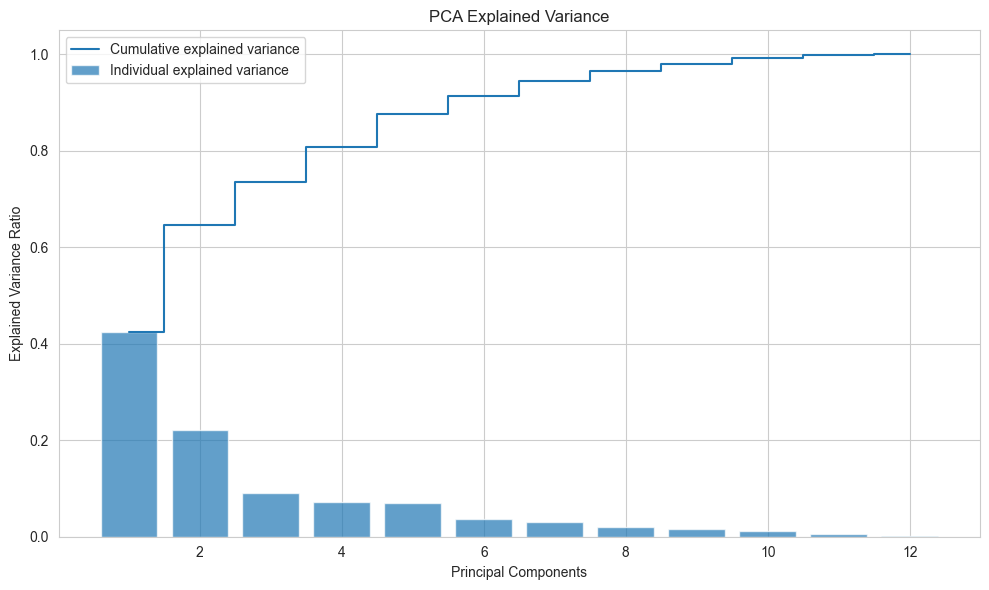

Cumulative explained variance ratio by number of components:
1 components: 0.42
2 components: 0.65
3 components: 0.74
4 components: 0.81
5 components: 0.88
6 components: 0.91
7 components: 0.94
8 components: 0.96
9 components: 0.98
10 components: 0.99
11 components: 1.00
12 components: 1.00

PCA Components and corresponding feature weights:
            X         Y      FFMC       DMC        DC       ISI      temp  \
PC1  0.936431  0.329039 -0.044517 -0.050069 -0.070967 -0.027932 -0.047009   
PC2  0.109744  0.030894  0.458172  0.446469  0.396524  0.398916  0.453903   
PC3 -0.018700  0.034205 -0.125524  0.430558  0.383359 -0.103124 -0.249114   
PC4 -0.198379  0.628818 -0.240968  0.092069  0.191048 -0.446965  0.250426   
PC5 -0.265992  0.689166  0.210817 -0.038348 -0.313068  0.405963 -0.152240   

           RH      wind      rain  season_Summer  day_type_Weekend  
PC1  0.046554  0.011296  0.004319      -0.000879          0.000040  
PC2 -0.187052 -0.068019  0.005635       0.124984        

In [150]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Create a DataFrame to check components and features contribution
components_df = pd.DataFrame(pca.components_, columns=X.columns)
components_df.index = [f'PC{i + 1}' for i in range(len(components_df))]

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7,
        label='Individual explained variance'
        )
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid',
         label='Cumulative explained variance'
         )
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Print the cumulative variance ratios
print("Cumulative explained variance ratio by number of components:")
for i, var_ratio in enumerate(cumulative_variance_ratio, start=1):
    print(f"{i} components: {var_ratio:.2f}")

# Print the components and weights per feature for the first few principal components
print("\nPCA Components and corresponding feature weights:")
print(components_df.head())

# Data split
We'll try some nonlinear models, but first we'll need to split the training, validation and test data. The most
important thing is to stratify by burned area, so each set contains a similar distribution of burned areas. The
`train_test_split` function doesn't allow stratification by continuous variables so we'll make some bins of the
distribution and stratify by those bins

Training set size: 309
Validation set size: 104
Test set size: 104


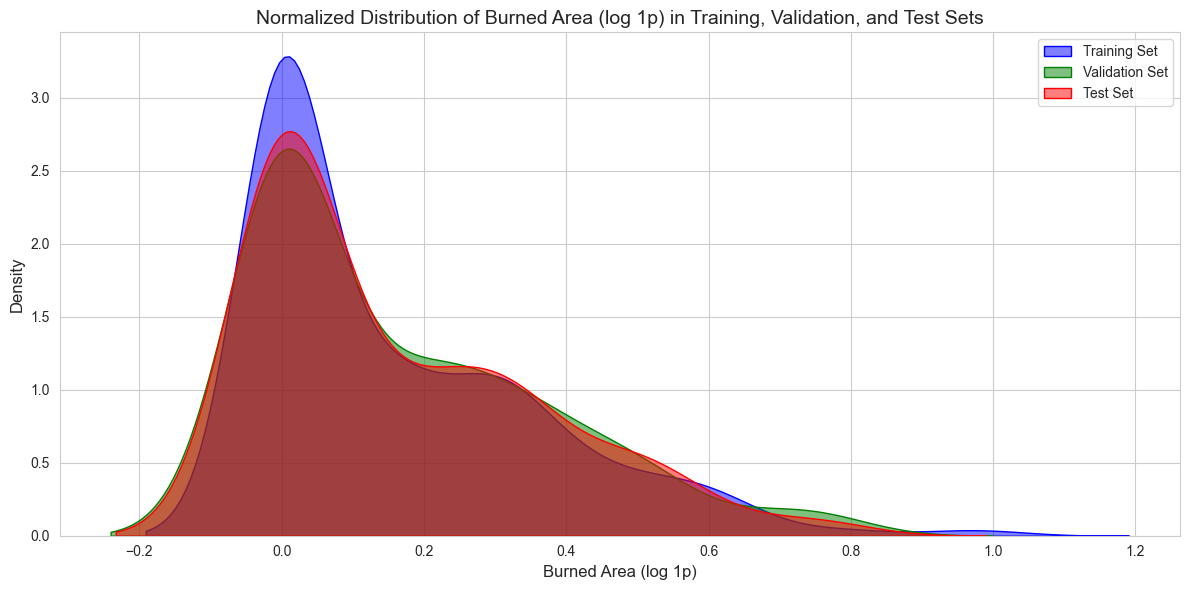

In [100]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Make a range of bins
bin_edges = np.arange(-0.5, 2, 0.25)
y_binned = pd.cut(y, bins=bin_edges, labels=False)

# Split the data into training, validation, and test sets
# First, split into train+validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

# We need to apply the same binning to the newly split set
y_train_val_binned = pd.cut(y_train_val, bins=bin_edges, labels=False)

# Then further split the train+validation set into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42,
                                                  stratify=y_train_val_binned
                                                  )

# Print the sizes of the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Plot the normalized distributions of burned area for each set
plt.figure(figsize=(12, 6))

# Training set distribution
sns.kdeplot(y_train, label='Training Set', color='blue', fill=True, alpha=0.5)

# Validation set distribution
sns.kdeplot(y_val, label='Validation Set', color='green', fill=True, alpha=0.5)

# Test set distribution
sns.kdeplot(y_test, label='Test Set', color='red', fill=True, alpha=0.5)

plt.xlabel('Burned Area (log 1p)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Normalized Distribution of Burned Area (log 1p) in Training, Validation, and Test Sets', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


We've split up the data into 3 sets, and their distributions are similar, but not identical, this will have an impact
 on results of evaluating models, there are relatively few fire events that burn large areas, so the arbitrary split
 of those into training, test or validation will have an effect. Still, it's a reasonable starting point,

# Linear model evaluation
In order to test other models, we need a way to score how well a given model performs on validation set. So we'll
write a function that makes use of the scorers we care about

In [144]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# Dictionary to store results for all models
model_results_dict = {}


def evaluate_model(model_instance, X_train, y_train, X_val, y_val):
    """
    Evaluate a single model instance or pipeline on given training and validation datasets.

    Parameters:
    - model_instance: The model instance or pipeline to evaluate.
    - X_train: Training feature data.
    - y_train: Training target data.
    - X_val: Validation feature data.
    - y_val: Validation target data.

    Returns:
    - results: dict, with evaluation metrics as keys and their values.
    """
    if isinstance(model_instance, Pipeline):
        # For pipelines, create the model name as a concatenation of the first step and the last step
        model_name = f"{model_instance.steps[0][1].__class__.__name__} + {model_instance.steps[-1][1].__class__.__name__}"
    else:
        # For regular models, use the class name
        model_name = model_instance.__class__.__name__

    print(f"Training model: {model_name}...")

    # Fit the model on training data
    model_instance.fit(X_train, y_train)

    # Predict on training and validation sets
    train_preds = model_instance.predict(X_train)
    val_preds = model_instance.predict(X_val)

    # Compute evaluation metrics
    train_mse = mean_squared_error(y_train, train_preds)
    val_mse = mean_squared_error(y_val, val_preds)
    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_val, val_preds)
    train_medae = median_absolute_error(y_train, train_preds)
    val_medae = median_absolute_error(y_val, val_preds)
    train_r2 = r2_score(y_train, train_preds)
    val_r2 = r2_score(y_val, val_preds)

    results = {
            'Train MSE'       : train_mse,
            'Validation MSE'  : val_mse,
            'Train MAE'       : train_mae,
            'Validation MAE'  : val_mae,
            'Train MedAE'     : train_medae,
            'Validation MedAE': val_medae,
            'Train R2'        : train_r2,
            'Validation R2'   : val_r2
    }

    # Append results to the global dictionary
    model_results_dict[model_name] = results

    # Display metrics in a figure
    fig, ax = plt.subplots(figsize=(10, 6))
    train_metrics = [results['Train MSE'], results['Train MAE'], results['Train MedAE'], results['Train R2']]
    val_metrics = [results['Validation MSE'], results['Validation MAE'], results['Validation MedAE'],
                   results['Validation R2']]

    x = range(len(train_metrics))
    ax.bar(x, train_metrics, width=0.4, label='Train Metrics', align='center')
    ax.bar([p + 0.4 for p in x], val_metrics, width=0.4, label='Validation Metrics', align='center')

    ax.set_xticks([p + 0.2 for p in x])
    ax.set_xticklabels(['MSE', 'MAE', 'MedAE', 'R2'], rotation=45, fontsize=12)
    ax.set_title(f"Model Evaluation Metrics: {model_name}", fontsize=16)
    ax.set_ylabel("Metric Values", fontsize=12)
    ax.legend()

    plt.tight_layout()
    plt.show()

    return results

Training model: LinearRegression...


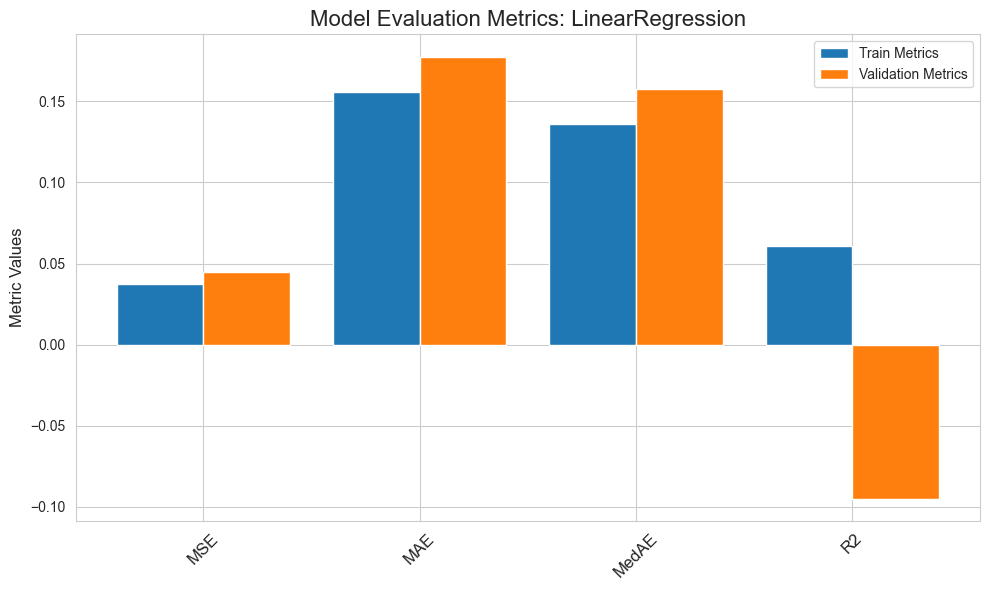

{'Train MSE': 0.03764393495808074,
 'Validation MSE': 0.044656703707594274,
 'Train MAE': 0.15595283912117214,
 'Validation MAE': 0.177722892598022,
 'Train MedAE': np.float64(0.13585137369549372),
 'Validation MedAE': np.float64(0.15752133243161198),
 'Train R2': 0.06081061428026724,
 'Validation R2': -0.09520349628118385}

In [102]:
linear_model = LinearRegression()
evaluate_model(linear_model, X_train, y_train, X_val, y_val)

Now that we have a helper function to visualise the results of a model, let's test a few out

We'll start with Ridge and Lasso regression

## Ridge

Training model: RidgeCV...


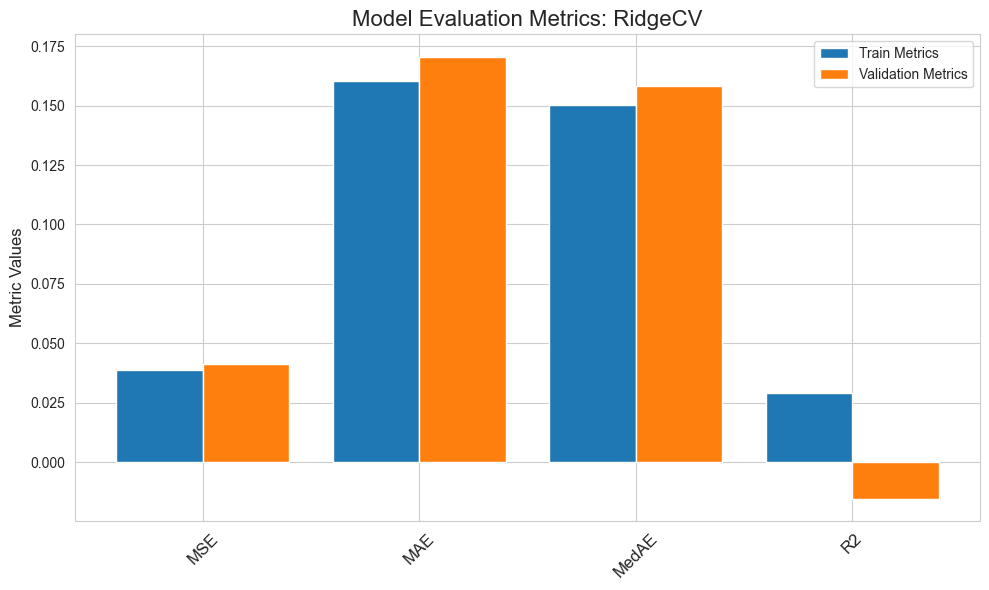

{'Train MSE': 0.038914460362958314, 'Validation MSE': 0.04140703111374195, 'Train MAE': 0.16055812787623636, 'Validation MAE': 0.17066317466344819, 'Train MedAE': np.float64(0.15026087445946468), 'Validation MedAE': np.float64(0.15832224527203115), 'Train R2': 0.029111909671488356, 'Validation R2': -0.015505433256640222}


In [103]:
# Import RidgeCV
from sklearn.linear_model import RidgeCV

# Create and evaluate the RidgeCV model
ridge = RidgeCV(alphas=np.arange(0.0001, 1000, 1), cv=5)
results_ridge = evaluate_model(ridge, X_train, y_train, X_val, y_val)
print(results_ridge)

In [129]:
print(ridge.alpha_)
print(ridge.coef_)

393.0001
[ 0.00252178  0.00130046 -0.00667005  0.00749415  0.00684411 -0.00898221
  0.00476197 -0.00376229  0.00796444 -0.00085787 -0.00399873 -0.00135592]


The alpha chosen for the ridge didn't push up against the boundary of ranges we defined. Similarly, the coefficients
for the features are not all 0. The change in MSE, MAE, MedAE and R2 suggest the model is underfitting. It is not
explaining much

## Lasso

Training model: LassoCV...


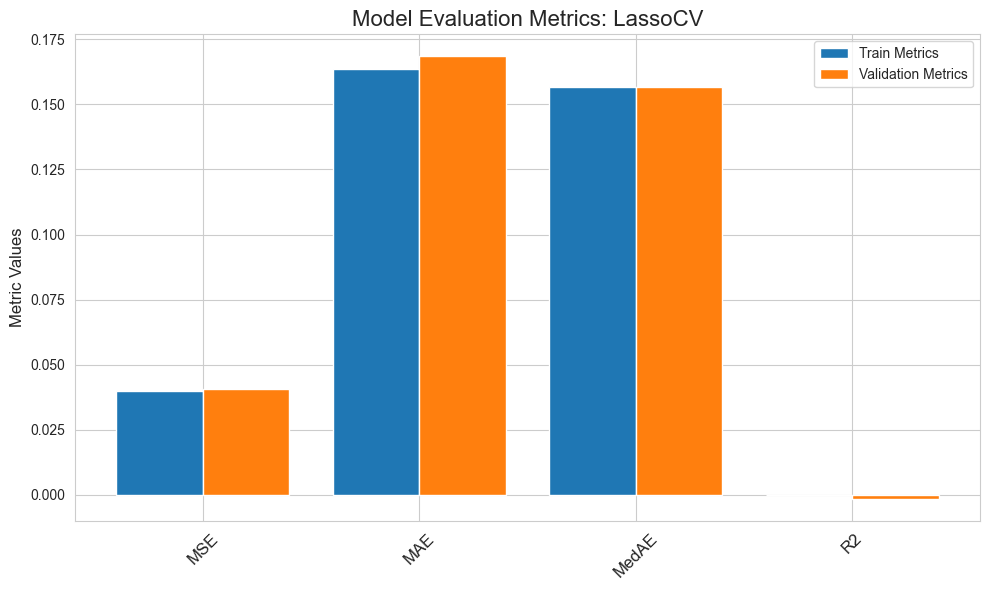

{'Train MSE': 0.040081303654462525, 'Validation MSE': 0.0408362780859211, 'Train MAE': 0.1635716943867191, 'Validation MAE': 0.16838519166126378, 'Train MedAE': np.float64(0.15671462755273777), 'Validation MedAE': np.float64(0.15671462755273777), 'Train R2': 0.0, 'Validation R2': -0.0015077428835339468}


In [104]:
# Import LassoCV
from sklearn.linear_model import LassoCV

# Create and evaluate the LassoCV model
lasso = LassoCV(alphas=np.arange(0.0001, 1000, 1), cv=5, random_state=random_state)
results_lasso = evaluate_model(lasso, X_train, y_train, X_val, y_val)
print(results_lasso)

In [130]:
print(lasso.alpha_)
print(lasso.coef_)

999.0001
[ 0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.]


The alpha of the lasso chosen was 999, right on the boundary of the range. The coefficients were all 0, so this model
 isn't doing anything

## RandomForestRegressor

Training model: RandomForestRegressor...


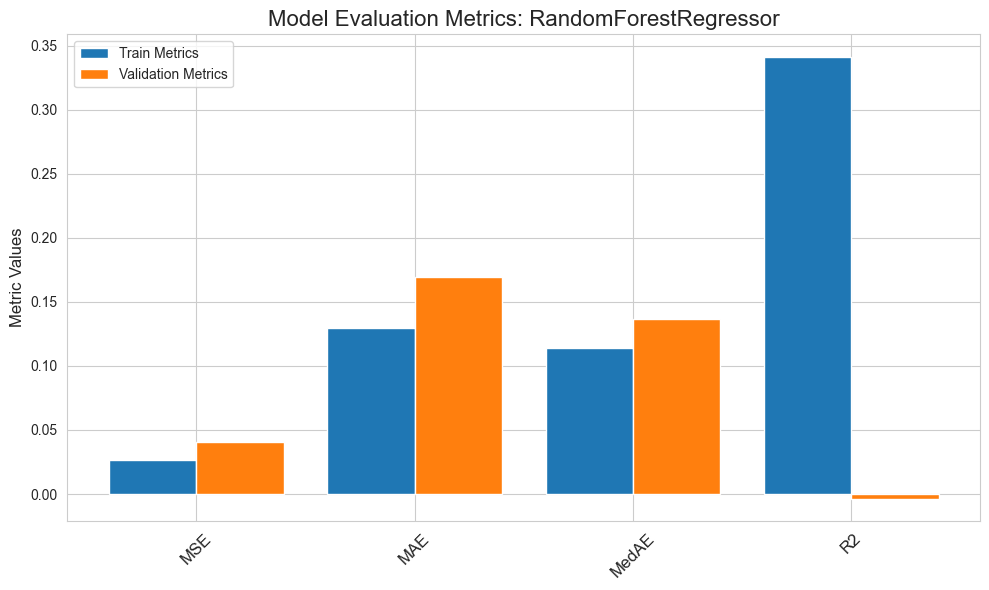

{'Train MSE': 0.02638508210466844, 'Validation MSE': 0.040929017943354046, 'Train MAE': 0.1298233809993309, 'Validation MAE': 0.16951865360236723, 'Train MedAE': np.float64(0.11391373821234019), 'Validation MedAE': np.float64(0.1368907548338483), 'Train R2': 0.34171097995883637, 'Validation R2': -0.0037821833968827434}


In [135]:
from sklearn.ensemble import RandomForestRegressor

# Create and evaluate the RandomForestRegressor model
random_forest = RandomForestRegressor(random_state=random_state, n_estimators=50, max_depth=4)  #

results_random_forest = evaluate_model(random_forest, X_train, y_train, X_val, y_val)
print(results_random_forest)

The random forest regressor is overfit for the training data but does not generalise well to the validation data.

## Stochastic Gradient Descent Regression

Training model: SGDRegressor...


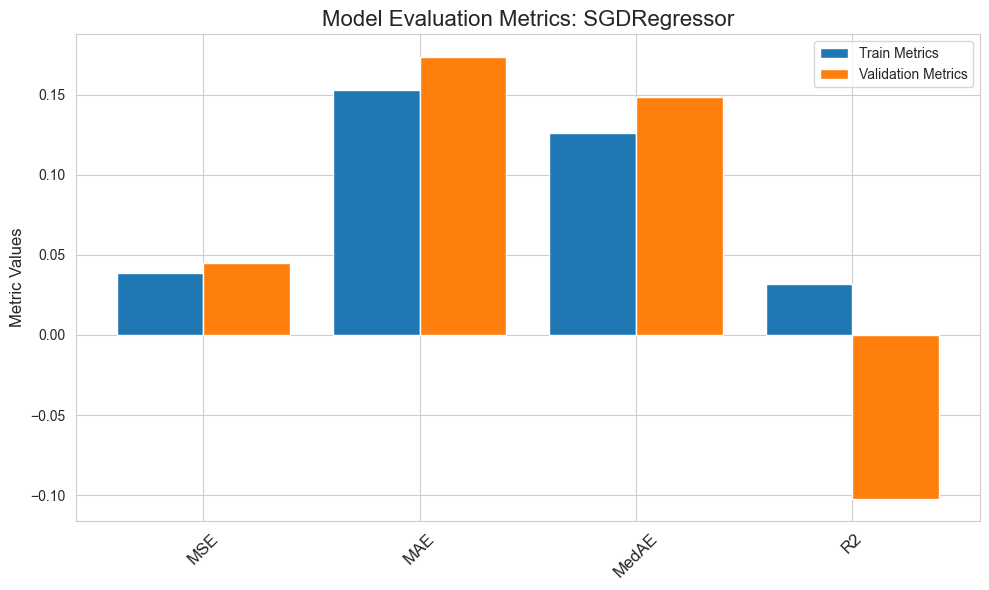

{'Train MSE': 0.03879259340606386, 'Validation MSE': 0.044947074806702875, 'Train MAE': 0.15291848053797813, 'Validation MAE': 0.17389573452021947, 'Train MedAE': np.float64(0.12598878861865392), 'Validation MedAE': np.float64(0.148484551018811), 'Train R2': 0.03215240351233384, 'Validation R2': -0.10232483342789922}


In [136]:
from sklearn.linear_model import SGDRegressor

# Create and evaluate the SGDRegressor model
sgd_regressor = SGDRegressor(random_state=random_state, max_iter=1000, tol=1e-3)
results_sgd = evaluate_model(sgd_regressor, X_train, y_train, X_val, y_val)
print(results_sgd)

The Stochastic Gradient Descent is underfitting, a low R2 that goes negative when moving to the validation set is a
clear sign the model is not predicting well.

## ElasticNetCV

Training model: ElasticNetCV...


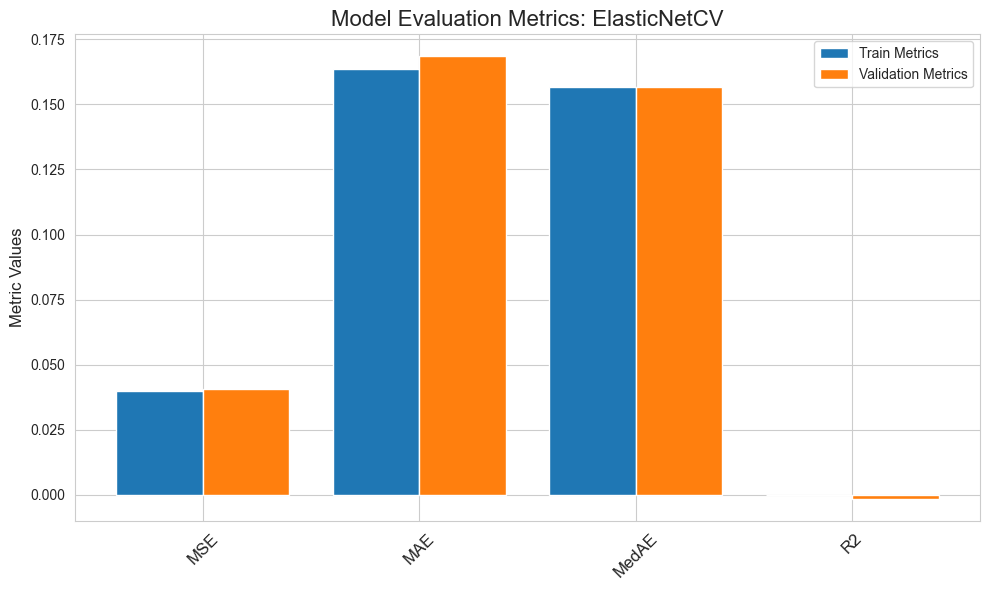

{'Train MSE': 0.040081303654462525, 'Validation MSE': 0.0408362780859211, 'Train MAE': 0.1635716943867191, 'Validation MAE': 0.16838519166126378, 'Train MedAE': np.float64(0.15671462755273777), 'Validation MedAE': np.float64(0.15671462755273777), 'Train R2': 0.0, 'Validation R2': -0.0015077428835339468}


In [107]:
# Import ElasticNetCV
from sklearn.linear_model import ElasticNetCV

# Create and fit the ElasticNetCV model
elastic_net = ElasticNetCV(alphas=np.arange(0.0001, 1000, 1), cv=5, random_state=random_state)

# Evaluate and print results
results_elastic_net = evaluate_model(elastic_net, X_train, y_train, X_val, y_val)
print(results_elastic_net)

An R2 of nearly 0 suggest the model is not taking into account any features, so has no predictive power stronger than
 taking the mean of the values

# Nonlinear model evaluation

## Polynomial


Training model: PolynomialFeatures + LinearRegression...


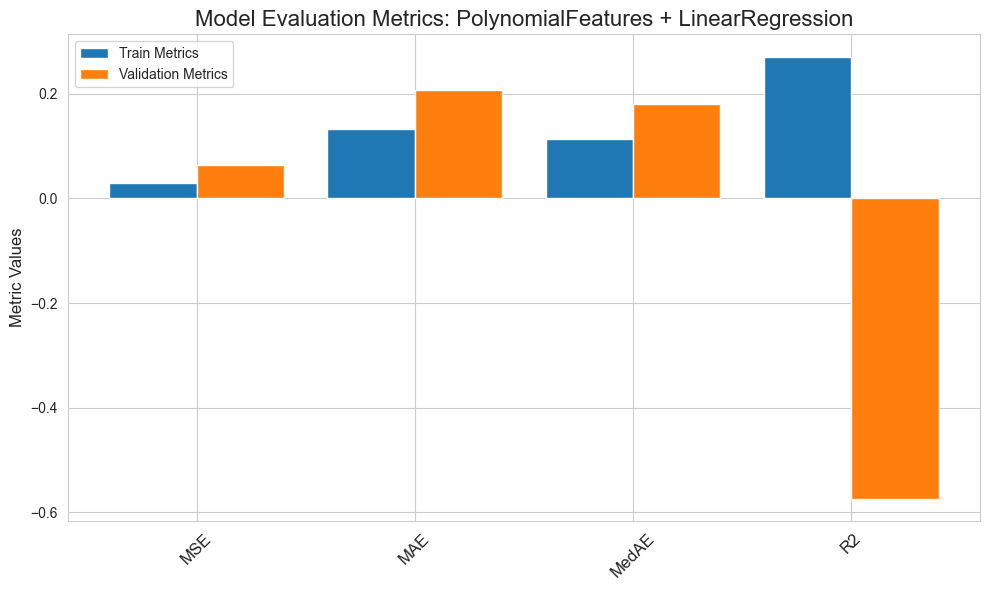

{'Train MSE': 0.02921527543535576, 'Validation MSE': 0.06418468254493002, 'Train MAE': 0.1324941614063077, 'Validation MAE': 0.2067280993531373, 'Train MedAE': np.float64(0.11267554494664428), 'Validation MedAE': np.float64(0.18076142690017957), 'Train R2': 0.27109967062902585, 'Validation R2': -0.5741262317789679}


In [108]:
# Import libraries for polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Create and evaluate the polynomial regression model (degree 2 as an example) using the evaluate_model function
polynomial_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
results_polynomial = evaluate_model(polynomial_model, X_train, y_train, X_val, y_val)

# Print the evaluation results
print(results_polynomial)

The 2nd order polynomial is overfitting, performing significantly worse on the validation set

## Spline

Training model: SplineTransformer + LinearRegression...


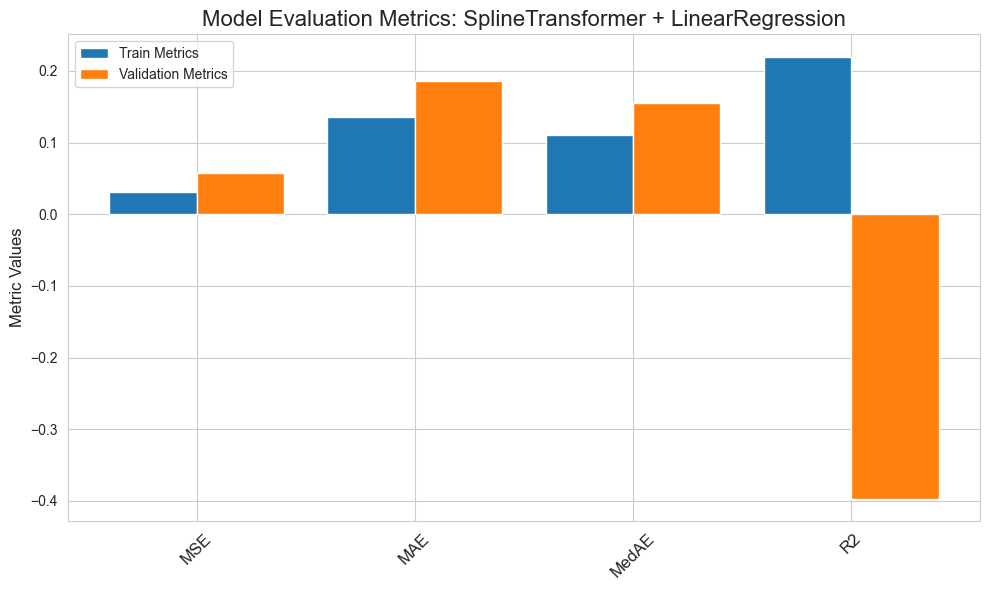

{'Train MSE': 0.03126069179660636, 'Validation MSE': 0.05697155311219297, 'Train MAE': 0.13590660794686305, 'Validation MAE': 0.18607789453724702, 'Train MedAE': np.float64(0.1103422666867353), 'Validation MedAE': np.float64(0.15535897414657018), 'Train R2': 0.2200679881547244, 'Validation R2': -0.3972245816798161}


In [109]:
# Import libraries for spline model
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Create and evaluate the spline model (degree 3 as an example) using the evaluate_model function
spline_model = make_pipeline(SplineTransformer(degree=3), LinearRegression())
results_spline = evaluate_model(spline_model, X_train, y_train, X_val, y_val)

# Print the evaluation results
print(results_spline)

The spline transformer also is overfitting.

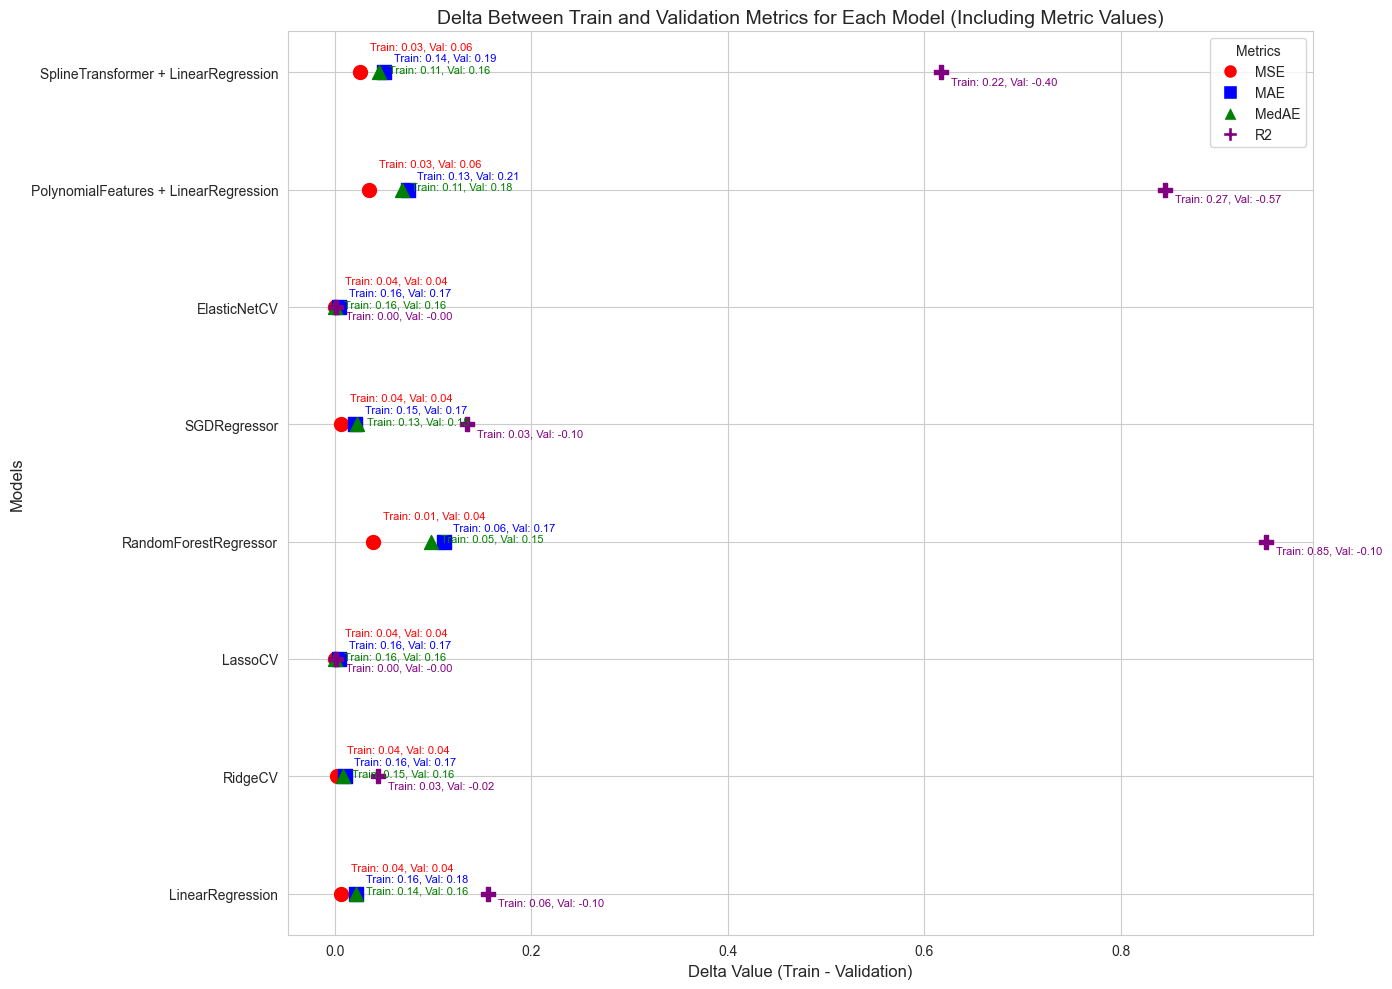

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming model_results is a dictionary with model names as keys and their evaluation results as values
model_names = list(model_results.keys())
metrics = ['Train MSE', 'Validation MSE', 'Train MAE', 'Validation MAE', 'Train MedAE', 'Validation MedAE', 'Train R2',
           'Validation R2']

# Calculate deltas between training and validation metrics for each model
delta_values = {model: {metric: abs(
    model_results[model]['Train ' + metric.split(' ')[1]] - model_results[model]['Validation ' + metric.split(' ')[1]]
)
        for metric in metrics if 'Train' in metric}
        for model in model_names}

# Transpose deltas for better grouping
grouped_deltas = {metric.split(' ')[1]: [delta_values[model][metric] for model in model_names] for metric in metrics if
                  'Train' in metric}

# Create a figure for plotting
plt.figure(figsize=(14, 10))
metrics_short = list(grouped_deltas.keys())  # Use short metric names for better labeling
x_positions = np.arange(len(metrics_short))  # Base x positions for each metric
symbols = ['o', 's', '^', 'P', 'X', 'D', 'v', '*']  # Symbols for different metrics
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'cyan', 'magenta']  # Colors for each metric

# Plot each model's deltas
for i, (model_name, model_deltas) in enumerate(delta_values.items()):
    model_delta_values = list(model_deltas.values())
    for j, delta_metric in enumerate(model_delta_values):
        plt.scatter(delta_metric, model_name, s=100, c=colors[j], marker=symbols[j])

    # Add metric values as text labels near each scatter point
    for j, metric in enumerate(metrics_short):
        train_metric = model_results[model_name]['Train ' + metric]
        val_metric = model_results[model_name]['Validation ' + metric]
        delta_metric = model_delta_values[j]
        plt.text(delta_metric + 0.01, i + 0.2 - 0.1 * j,
                 f"Train: {train_metric:.2f}, Val: {val_metric:.2f}",
                 fontsize=8, color=colors[j]
                 )

# Adding a custom color-coded legend for metrics
legend_handles = [plt.Line2D([0], [0], marker=symbols[i], color='w', label=metric,
                             markerfacecolor=colors[i], markersize=10
                             ) for i, metric in enumerate(metrics_short)]
plt.legend(handles=legend_handles, title='Metrics', fontsize=10, loc='upper right')

# Adding labels, title, and other details
plt.xlabel('Delta Value (Train - Validation)', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.title('Delta Between Train and Validation Metrics for Each Model (Including Metric Values)', fontsize=14)
plt.tight_layout()
plt.show()

# Model comparisons
None of the models has performed particularly well when moving from training data to validation data. It could be
that even with stratifying to keep the distributions the same, the differences are enough to make fitting a model
difficult. There's only 309 data points in the training set. Attempting to stratify the models to have a similar
distribution is only going to be effective if we have thousands of datapoints to make sure the distributions are
continuous.

Rather than use test_train_split we'll use KFold Cross Validation instead and train on the full data set

# K-Fold Cross Validation of models
We'll use a K of 5, because that's comparable to how we split the data using `test_train_split`

In [137]:
from sklearn.model_selection import KFold, cross_val_score

# Evaluate Ridge using K-Fold Cross Validation
ridge = RidgeCV(alphas=np.arange(0.0001, 1000, 1), cv=5)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
ridge_results = cross_val_score(ridge, X, y, cv=kf, scoring='neg_mean_squared_error')
print("Ridge CV Results (MSE):", -ridge_results.mean())

ridge.fit(X, y)
print("Ridge Alpha:", ridge.alpha_)
print("Ridge Coefficients:", ridge.coef_)
from sklearn.ensemble import RandomForestRegressor

# Evaluate RandomForestRegressor using K-Fold Cross Validation
random_forest = RandomForestRegressor(random_state=random_state, n_estimators=50, max_depth=4)
rf_results = cross_val_score(random_forest, X, y, cv=kf, scoring='neg_mean_squared_error')
print("RandomForest CV Results (MSE):", -rf_results.mean())
from sklearn.linear_model import SGDRegressor

# Evaluate SGDRegressor using K-Fold Cross Validation
sgd_regressor = SGDRegressor(random_state=random_state, max_iter=1000, tol=1e-3)
sgd_results = cross_val_score(sgd_regressor, X, y, cv=kf, scoring='neg_mean_squared_error')
print("SGD CV Results (MSE):", -sgd_results.mean())
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Evaluate Polynomial Regression using K-Fold Cross Validation
polynomial_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_results = cross_val_score(polynomial_model, X, y, cv=kf, scoring='neg_mean_squared_error')
print("Polynomial CV Results (MSE):", -poly_results.mean())
from sklearn.preprocessing import SplineTransformer

# Evaluate Spline Regression using K-Fold Cross Validation
spline_model = make_pipeline(SplineTransformer(degree=3), LinearRegression())
spline_results = cross_val_score(spline_model, X, y, cv=kf, scoring='neg_mean_squared_error')
print("Spline CV Results (MSE):", -spline_results.mean())

Ridge CV Results (MSE): 0.03984053025279465
Ridge Alpha: 999.0001
Ridge Coefficients: [ 0.00393294  0.00130268  0.00099212  0.00355414  0.00324611 -0.00109802
  0.00222124 -0.00312918  0.00442453 -0.00066805 -0.00287982  0.00148782]
RandomForest CV Results (MSE): 0.0409261283423533
SGD CV Results (MSE): 0.04177409301967902
Polynomial CV Results (MSE): 0.05412465793691616
Spline CV Results (MSE): 0.04466006402164048


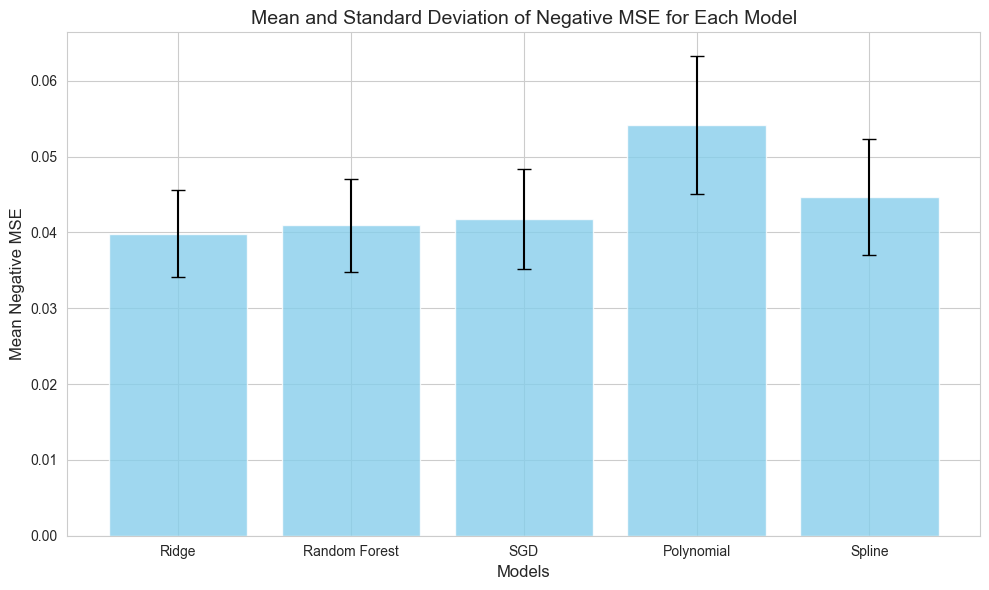

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the average and standard deviation of the models
model_results = [
        -ridge_results.mean(),
        -rf_results.mean(),
        -sgd_results.mean(),
        -poly_results.mean(),
        -spline_results.mean()
]
model_stds = [
        ridge_results.std(),
        rf_results.std(),
        sgd_results.std(),
        poly_results.std(),
        spline_results.std()
]

# Define model names
model_names = ['Ridge', 'Random Forest', 'SGD', 'Polynomial', 'Spline']

# Plot mean and standard deviation
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_results, yerr=model_stds, capsize=5, color='skyblue', alpha=0.8)
plt.ylabel('Mean Negative MSE', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.title('Mean and Standard Deviation of Negative MSE for Each Model', fontsize=14)
plt.tight_layout()
plt.show()

From this evaluation, the RidgeCV has performed the best. With a slightly lower MSE

# Model from paper
In the original data set, it specifies the type of model used, so we'll construct that as well to compare. Relevant text

```In (Cortez and Morais), 2007, the output 'area' was first transformed with a ln(x+1) function.
   Then, several Data Mining methods were applied. After fitting the models, the outputs were
   post-processed with the inverse of the ln(x+1) transform. Four different input setups were
   used. The experiments were conducted using a 10-fold (cross-validation) x 30 runs. Two
   regression metrics were measured: MAD and RMSE. A Gaussian support vector machine (SVM) fed
   with only 4 direct weather conditions (temp, RH, wind and rain) obtained the best MAD value:
   12.71 +- 0.01 (mean and confidence interval within 95% using a t-student distribution). The
   best RMSE was attained by the naive mean predictor. An analysis to the regression error curve
   (REC) shows that the SVM model predicts more examples within a lower admitted error. In effect,
   the SVM model predicts better small fires, which are the majority. ```


In [142]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Select only four weather-related features and apply transformation to the target.
X_svm = fires_processed[["temp", "RH", "wind", "rain"]]
y_svm = np.log1p(fires_processed["area"])  # ln(x+1) transformation

# Create a Gaussian SVM regressor
svm_model = SVR(kernel="rbf", C=1.0, epsilon=0.1)

# Apply 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=random_state)

# Cross-validate MAE
mae_scores = cross_val_score(
    svm_model, X_svm, y_svm, cv=kf, scoring="neg_mean_absolute_error"
)
mad_mean = -mae_scores.mean()
mad_confidence_interval = 1.96 * mae_scores.std() / np.sqrt(len(mae_scores))

# Cross-validate RMSE
rmse_scores = cross_val_score(
    svm_model, X_svm, y_svm, cv=kf, scoring="neg_root_mean_squared_error"
)
rmse_mean = -rmse_scores.mean()

# Output evaluation results
print(f"Mean Absolute Deviation (MAD): {mad_mean:.2f} ± {mad_confidence_interval:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_mean:.2f}")


Mean Absolute Deviation (MAD): 1.08 ± 0.10
Root Mean Squared Error (RMSE): 1.51


Training model: SVR...


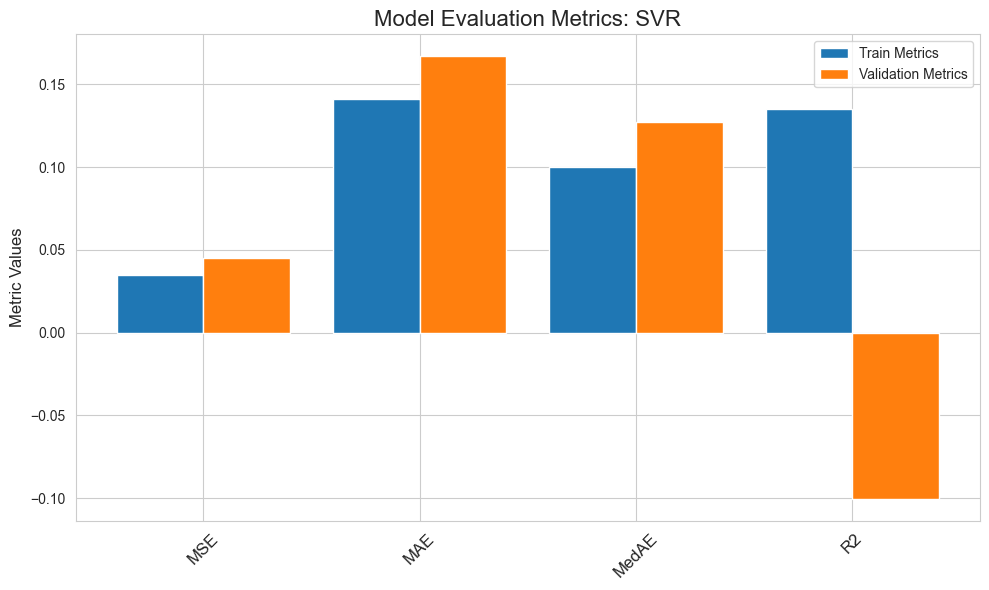

{'Train MSE': 0.034667513873848615, 'Validation MSE': 0.04486711382776579, 'Train MAE': 0.14141806929983322, 'Validation MAE': 0.16687269003263763, 'Train MedAE': np.float64(0.10025987773012611), 'Validation MedAE': np.float64(0.1272299709266157), 'Train R2': 0.13507020198957898, 'Validation R2': -0.10036379429094477}


In [145]:
# Evaluate SVM model using the evaluate_model function
results_svm = evaluate_model(svm_model, X_train, y_train, X_val, y_val)

# Print the evaluation results for the SVM model
print(results_svm)


From this we can be confident that the test_train_split approach is not good for evaluating the model performance.
Let's try a different approach

In [148]:
from sklearn.metrics import make_scorer

# Custom scoring functions for MAD and RMSE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform cross-validation for SVM
kf = KFold(n_splits=10, shuffle=True, random_state=random_state)

# Cross-validated Mean Absolute Deviation (MAD)
svm_mad_scores = cross_val_score(svm_model, X_svm, y_svm, cv=kf, scoring=mae_scorer)
svm_mad_mean = -svm_mad_scores.mean()
svm_mad_std = svm_mad_scores.std()

# Cross-validated Root Mean Squared Error (RMSE)
svm_rmse_scores = cross_val_score(svm_model, X_svm, y_svm, cv=kf, scoring=rmse_scorer)
svm_rmse_mean = -svm_rmse_scores.mean()
svm_rmse_std = svm_rmse_scores.std()

# Print the SVM Cross-Validation Results
print(f"SVM Cross-validated MAD: {svm_mad_mean:.2f} ± {1.96 * svm_mad_std:.2f}")
print(f"SVM Cross-validated RMSE: {svm_rmse_mean:.2f} ± {1.96 * svm_rmse_std:.2f}")


SVM Cross-validated MAD: 1.08 ± 0.30
SVM Cross-validated RMSE: 2.34 ± 1.31


# Conclusion
Applying linear models to forest fires does not yield great results.

Evaluating the models. None have performed well enough to predict forest fires with a high enough accuracy to be
worth implementing.

## Next steps
Based on the paper, the FWI factors have temporal memory, so building a model that takes into account the weighted
values of previous measures of meteorlogical data would be helpful

Additionally, the physical location of fires and their total burned area may be related to topographical features. It
 may also be correlated with areas visited by people

The time of day and full date of the fires could provide more information by correlating with other weather data
sources.

